In [1]:
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import sys, os
import numpy as np
from collections import Counter

In [2]:
def get_parameter_str(fname, param_name):
    for i in range(len(fname)):
        if fname[i:i + len(param_name)] == param_name:
            break
            
    start_pos = i + len(param_name)
    value = ''
    
    for j in range(start_pos, len(fname)):
        if fname[j] != '_':
            value += fname[j]
        else:
            break
            
    return value


def load_num_lineages(results_dir, dtwf_shift=1):
    lineages_df = pd.DataFrame()
    time_df = pd.DataFrame()

    params_df = pd.DataFrame()
    param_names = ["Ne", "nchroms", "model", "growth_rate", "sample_size"]
    params_dtypes = [int, int, str, float, int]
    params_list = []
    
    i = 0
    for fname in os.listdir(results_dir):
        if fname[-3:] != 'txt':
            continue

        try:
            df = pd.read_csv(os.path.join(results_dir, fname), header=None, sep='\t')
        except:
            print("Error reading", fname, "- skipping")
            continue
            
        sim_params = {p: get_parameter_str(fname, p) for p in param_names}
        params_list.append([t(sim_params[p]) for t, p in zip(params_dtypes, param_names)])
            
        Ne = int(sim_params["Ne"])
        nchroms = int(sim_params["nchroms"])
        model = sim_params["model"]
        growth_rate = float(sim_params["growth_rate"])
        sample_size = int(sim_params["sample_size"])
        
        df.columns = ("time", i)
                
        if model == 'dtwf':
            df['time'] = df['time'] - dtwf_shift
                                
        lineages_df = pd.concat([lineages_df, df[i]], axis=1)
        time_df = pd.concat([time_df, df['time']], axis=1)
        time_df = time_df.rename(columns={'time': i})
            
        i += 1
        
    params_df = pd.DataFrame(params_list)
    params_df.columns = param_names
        
    return lineages_df, time_df, params_df


def get_cols_to_plot(params_df, params_dict):
    plot_cols = []
    for col in params_df.columns:
        add = 1
        for key, value in params_dict.items():
            if params_df[col][key] != value:
                add = 0
        if add == 1:
            plot_cols.append(col)
            
    return plot_cols


def get_labels(params_df, cols, label_key):
    
    return params_df[cols].loc[label_key].values
    

def plot_params(lineages_df, time_df, params_df, params_dict, label_key, ax, zero_point=None):
    cols = get_cols_to_plot(params_df, params_dict)
    labels = get_labels(params_df, cols, label_key)
    
    for c, l in zip(cols, labels):
        times = time_df[c].values
        lineages = lineages_df[c].values
        
        if zero_point is not None:
#             assert lineages[0] == 0
            times[0] = zero_point
        ax.plot(times, lineages, label=l)

In [3]:
ldf, tdf, pdf = load_num_lineages('/Users/dnelson/project/wf_coalescent/results/beluga/')

fig, ax_arr = plt.subplots(1, 2, figsize=(6.5, 4.5), sharex=True, sharey=True)

# Plot DTWF
to_plot = {'model': 'dtwf',
          'Ne': 10000,
          'nchroms': 22}
plot_cols = plot_params(ldf, tdf, pdf.transpose(), to_plot, 'sample_size', ax_arr[1], zero_point=1e-4)

# Plot Hudson
to_plot = {'model': 'hudson',
          'Ne': 10000,
          'nchroms': 22}
plot_cols = plot_params(ldf, tdf, pdf.transpose(), to_plot, 'sample_size', ax_arr[0])

# Plot Ne
Ne = 10000
Ne_haploid = Ne * 2
growth_rate = 0.001

x = np.linspace(0, 10000, 10000)
y = [Ne_haploid * np.exp(-growth_rate * t) for t in x]

# Set legend and axis labels
handles, labels = ax_arr[1].get_legend_handles_labels()
labels = [int(x) for x in labels]
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: -t[0]))
ax_arr[1].legend(handles, labels, title='Sample Size')

ax_arr[0].plot(x, y, '--', color='lightgrey')
ax_arr[1].plot(x, y, '--', color='lightgrey')

ax_arr[0].set_xscale('log')
ax_arr[1].set_xscale('log')
ax_arr[0].set_xlabel('Generations (in the past)')
ax_arr[1].set_xlabel('Generations (in the past)')
ax_arr[0].set_ylabel('Number of lineages')

ax_arr[0].set_title('Hudson')
ax_arr[1].set_title('Wright-Fisher')

fig.tight_layout()
fig.savefig(os.path.expanduser('~/temp/test_num_lineages.pdf'))
fig.show()

In [111]:
ldf

,0,1,2,3,4,5,6,7,8,9
0,10000.0,10000.0,1000.0,1000.0,2000.0,2000.0,5000.0,5000.0,500.0,500
1,12756.0,10483.0,1910.0,1056.0,3630.0,2098.0,7866.0,5236.0,964.0,523
2,14422.0,10979.0,3502.0,1108.0,6106.0,2193.0,10842.0,5488.0,1828.0,553
3,15212.0,11502.0,5826.0,1161.0,9114.0,2301.0,13394.0,5720.0,3330.0,580
4,15526.0,11992.0,8921.0,1205.0,11972.0,2397.0,14748.0,5977.0,5632.0,604
5,15665.0,12442.0,11729.0,1257.0,13789.0,2510.0,15356.0,6216.0,8601.0,625
6,15765.0,12932.0,13683.0,1314.0,14883.0,2610.0,15578.0,6470.0,11447.0,644
7,15789.0,13392.0,14696.0,1354.0,15350.0,2695.0,15683.0,6700.0,13415.0,665
8,15817.0,13866.0,15181.0,1398.0,15591.0,2803.0,15678.0,6955.0,14443.0,693
9,15707.0,14390.0,15431.0,1436.0,15610.0,2909.0,15717.0,7185.0,14767.0,713


In [93]:

fig.show()

/Users/dnelson/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
stats.norm.pdf(np.arange(-5, 5), loc=2.135, scale=0.942)
# loc=0.941, scale=1.02

array([1.47599428e-13, 2.60850879e-10, 1.49375386e-07, 2.77169146e-05,
       1.66644058e-03, 3.24648863e-02, 2.04935430e-01, 4.19178805e-01,
       2.77818197e-01, 5.96624618e-02])

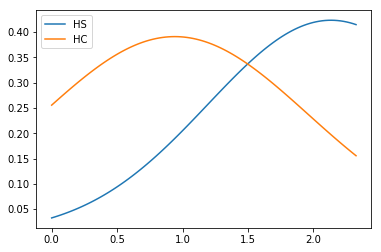

In [3]:
x = np.linspace(0, stats.norm.ppf(0.99), 100)
diff = x[1] - x[0]
plt.plot(x, stats.norm.pdf(x, loc=2.135, scale=0.942), label="HS")
plt.plot(x, stats.norm.pdf(x, loc=0.941, scale=1.02), label="HC")
plt.legend()

In [4]:
def nfold_convolve(x, n):
    for i in range(n):
        print(i)
        while x[-1] < 1e-5:
            x = x[:-1]
        x = np.convolve(x, x)
        
    return x

In [5]:
y = nfold_convolve(stats.norm.pdf(x, loc=2.135, scale=0.942), n=10)

0
1
2
3
4
5
6
7
8
9


/home/dnelson/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:1943: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


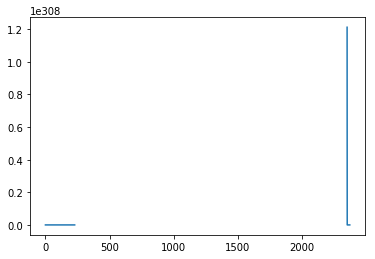

In [6]:
plt.plot(np.arange(0, len(y)) * diff, y, label="HS")

In [1]:
import pacal

Using compiled interpolation routine
Using compiled sparse grid routine


In [20]:
HS = pacal.NormalDistr(2.135,0.942)
n = 10
for i in range(n):
    HS = HS + HS

In [ ]:
HS.plot()